In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(21)

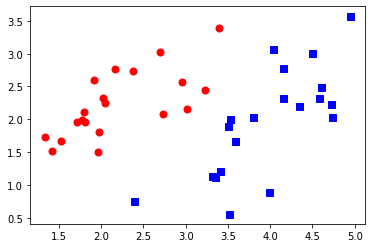

In [36]:
means = [[2, 2], [4, 2]]
cov = [[.3, .2], [.2, .3]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
plt.plot(X0[:, 0], X0[:, 1], 'ro', markersize=7)
plt.plot(X1[:, 0], X1[:, 1], 'bs', markersize=7)
plt.show()

In [44]:
X = np.concatenate((X0, X1), axis=0)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis=1).reshape(2*N,)
print(X.shape)
print(y.shape)

(40, 2)
(40,)


In [60]:
#SKLEARN
from sklearn.svm import SVC
C = 100
clf = SVC(kernel = 'linear', C=C)
clf.fit(X, y)

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print(w_sklearn.T, '\n', b_sklearn)

[[-5.63619298  3.99138038]] 
 9.428581334546687


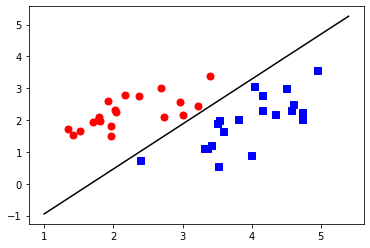

In [61]:
xn = np.arange(1, 5.5, .1)
yn = -w_sklearn.T[0, 0]/w_sklearn.T[0, 1]*xn - b_sklearn/w_sklearn.T[0, 1]

plt.plot(X0[:, 0], X0[:, 1], 'ro', markersize=7)
plt.plot(X1[:, 0], X1[:, 1], 'bs', markersize=7)
plt.plot(xn, yn, 'k')
plt.show()

In [63]:
# By dual problems
from cvxopt import matrix, solvers

V = np.concatenate((X0.T, -X1.T), axis=1)
K = matrix(V.T.dot(V))

p = matrix(-np.ones((2*N, 1)))
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))

h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))
solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x'])
print('lambda = \n', l.T)

lambda = 
 [[2.50910007e-08 3.49493110e-08 9.11660651e-08 1.07269897e-06
  2.02649946e-07 4.30506205e-08 2.38615836e+01 2.18362714e-08
  2.66473821e-08 2.50526462e-08 2.90936222e-08 1.87615292e-08
  1.40186891e-07 1.84414421e-08 6.86549093e-08 2.41921307e-08
  2.47319243e-08 2.76775367e-08 2.88865955e-08 2.60327576e-08
  1.58881850e-07 1.40564077e-08 2.30822200e-08 1.44632230e-07
  1.93310492e-07 5.66639997e-08 6.21583589e-08 3.68023683e-08
  2.87621672e-08 3.31867166e-08 2.01677264e-08 7.85658249e-08
  1.57035136e+01 6.19547573e-08 5.61224432e-08 7.29418734e-08
  8.15807075e+00 8.49492524e-08 8.51279007e-08 1.44417344e-08]]


In [68]:
S = np.where(l > 1e-5)[0]
S2 = np.where(l < .99*C)[0]

M = [val for val in S if val in S2] #intersection of two lists
#M = list(set(S) & set(S2))
print(M)

[6, 32, 36]


In [70]:
XT = X.T # each col is one data point in this alg
VS = V[:, S]
lS = l[S]
yM = y[M]
XM = XT[:, M]
w_dual = VS.dot(lS).reshape(-1, 1)
b_dual = np.mean(yM.T - w_dual.T.dot(XM))

print(w_dual.T)
print(b_dual)

[[-5.63787108  3.99219033]]
9.432273329077546


In [73]:
#Khong rang buoc
X0_bar = np.vstack((X0.T, np.ones((1, N))))
X1_bar = np.vstack((X1.T, np.ones((1, N))))

Z = np.hstack((X0_bar, -X1_bar))
lam = 1./C

def cost(w):
    u = w.T.dot(Z)
    return (np.sum(np.maximum(0, 1-u)) + .5*lam*np.sum(w*w)) - .5*lam*w[-1]*w[-1]

def grad(w):
    u = w.T.dot(Z)
    H = np.where(u < 1)[1]
    ZS = Z[:, H]
    g = (-np.sum(ZS, axis=1, keepdims=True) + lam*w)
    g[-1] -= lam*w[-1]
    return g

eps = 1e-6

def num_grad(w):
    g = np.zeros_like(w)
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps
        wm[i] -= eps
        g[i] = (cost(wp) - cost(wm))/(2*eps)
    return g

w0 = np.random.randn(X0_bar.shape[0], 1)
g1 = grad(w0)
g2 = num_grad(w0)
diff = np.linalg.norm(g1 - g2)
print('Gradient different: %f' %diff)

Gradient different: 0.000000


In [76]:
"""
Vì sự khác nhau giữa hai cách tính gradient là bằng 0 => Phép tính Gradient Descent chính xác:
"""
def grad_descent(w0, eta):
    w = w0
    it = 0
    while it < 100000:
        it = it +1
        g = grad(w)
        w -= eta*g
        if (it % 10000) == 1:
            print('iter %d' %it + ' cost: %f' %cost(w))
        if np.linalg.norm(g) < 1e-5:
            break
    return w

w0 = np.random.randn(X0_bar.shape[0], 1)
w = grad_descent(w0, 0.001)
w_hinge = w[: -1].reshape(-1, 1)
b_hinge = w[-1]

print(w_hinge.T)
print(b_hinge)

iter 1 cost: 51.865309
iter 10001 cost: 1.274161
iter 20001 cost: 0.798690
iter 30001 cost: 0.378844
iter 40001 cost: 0.239039
iter 50001 cost: 0.259449
iter 60001 cost: 0.264099
iter 70001 cost: 0.239495
iter 80001 cost: 0.239233
iter 90001 cost: 0.239031
[[-5.64631502  3.99448732]]
[9.4364721]


In [77]:
print(w_sklearn.T)
print(b_sklearn)
print(w_dual.T)
print(b_dual)
print(w_hinge.T)
print(b_hinge)

[[-5.63619298  3.99138038]]
9.428581334546687
[[-5.63787108  3.99219033]]
9.432273329077546
[[-5.64631502  3.99448732]]
[9.4364721]
